In [ ]:
# 


In [356]:
import geopandas as gpd
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
from datetime import timedelta
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
import numpy as np
import numpy as npm
import osmnx as ox
import math
import pandas as pd
from shapely.ops import snap
from tqdm import tqdm
import re

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [357]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [358]:
def peek(df):
    print(len(df))
    display(df.iloc[0:3])

In [359]:
stops_nodes_df = pd.read_csv(f'{EXPORTS_DIR}/csv/manhattan/stops_nodes.csv')
stops_nodes_df = stops_nodes_df.set_index('stop_id')
peek(stops_nodes_df)

1780


,stop_name,stop_lat,stop_lon,M1,M10,M100,M101,M102,M103,M104,...,M5,M50,M55,M57,M66,M7,M72,M8,M9,M96
stop_id,,,,,,,,,,,,,,,,,,,,,
400001,4 AV/E 10 ST,40.731342,-73.990292,POINT (-73.99037 40.73135299999986),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400002,4 AV/E 12 ST,40.732608,-73.989958,POINT (-73.990059 40.73262099999981),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400003,4 AV/E 13 ST,40.733936,-73.989720,POINT (-73.98985 40.73393799999985),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [360]:
route_ids = list(stops_nodes_df.columns[3:])

In [361]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [362]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    attrs = nx.get_edge_attributes(G, 'speed')
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    edges_gdf = edges_gdf.drop(columns={
        'route_shor',
        'route_long',
        'color',
        'ShpName',
        'Wkb',
        'Wkt',
        'Json',
    })
    return edges_gdf

In [363]:
def get_node(mg, point):
    threshold = 0.00001
    for node in route_mg.nodes():
        if abs(node[0] - point[0]) < threshold and abs(node[1] - point[1]) < threshold:
            return node
    return None

In [364]:
route_mgs = []

for route_id in route_ids:
    route_mg = nx.read_shp(f'{EXPORTS_DIR}/shp/manhattan/routes/{route_id}.shp', simplify=False)
    route_mg.graph['crs'] = CRS_LATLON
    route_mgs.append(route_mg)

In [365]:
all_routes_mg = route_mgs[0]

for i, route_mg in enumerate(route_mgs[1:]):
    all_routes_mg = nx.compose(all_routes_mg, route_mg)

In [366]:
import pickle
f = open(f'{EXPORTS_DIR}/pkl/avg_speed_attr_dict.pkl', 'rb')
avg_speed_attr_dict = pickle.load(f)
f.close()

In [367]:
f = open(f'{EXPORTS_DIR}/pkl/all_trip_attr_dict.pkl', 'rb')
all_trip_attr_dict = pickle.load(f)
f.close()

In [368]:
nx.set_edge_attributes(all_routes_mg, avg_speed_attr_dict)

In [369]:
all_nodes_gdf = graph_to_node_gdf(all_routes_mg)
all_edges_gdf = graph_to_edge_gdf(all_routes_mg)

In [374]:
edges = ((edge[0], edge[1]) for edge in all_routes_mg.edges(data=True) if 'speeds_0' in edge[2])
speed_mg = all_routes_mg.edge_subgraph(edges)
nx.set_edge_attributes(speed_mg, avg_speed_attr_dict)

In [375]:
speed_edges_gdf = graph_to_edge_gdf(speed_mg)

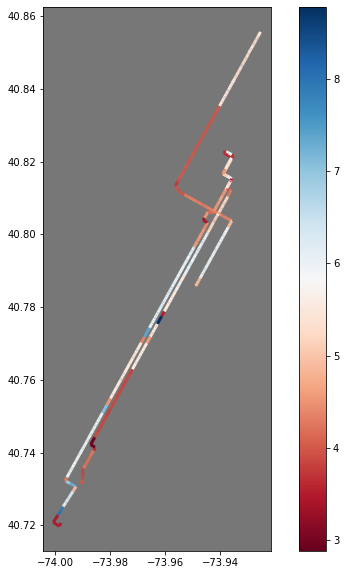

In [376]:
fig, ax = plt.subplots(figsize=(10, 10))
speed_edges_gdf.plot(ax=ax, column='speeds_0', cmap='RdBu', zorder=2, linewidth=3, legend=True)
ax.set_facecolor('#777')

In [377]:
trip_mg = speed_mg
nx.set_edge_attributes(trip_mg, all_trip_attr_dict)
trip_edges_gdf = graph_to_edge_gdf(trip_mg)
trip_edges_gdf = trip_edges_gdf.reset_index()
trip_edges_gdf = trip_edges_gdf.rename(columns={'index': 'edge'})
trip_edges_gdf = trip_edges_gdf.drop(columns=['route_id', 'route_dir', 'speeds_0', 'speeds_1', 'speeds_2', 'geometry', 'length'])
peek(trip_edges_gdf)

635


,edge,speeds_3,OF_C1-Weekday-036000_M1_102,OF_C1-Weekday-038700_M1_103,OF_C1-Weekday-040200_M1_104,OF_C1-Weekday-041700_M1_105,OF_C1-Weekday-043100_M1_106,OF_C1-Weekday-044600_M1_107,OF_C1-Weekday-046100_M1_108,OF_C1-Weekday-047600_M1_109,...,OH_C1-Weekday-SDon-137500_M101_130,OH_C1-Weekday-SDon-139000_M101_134,OH_C1-Weekday-SDon-140000_M101_113,OH_C1-Weekday-SDon-141000_M101_136,OH_C1-Weekday-SDon-142000_M101_116,OH_C1-Weekday-SDon-143000_M101_138,OH_C1-Weekday-SDon-145000_M101_140,OH_C1-Weekday-SDon-146500_M101_137,OH_C1-Weekday-SDon-148000_M101_139,OH_C1-Weekday-SDon-149500_M101_133
0,"(-73.984339, 40.74585199999984, -73.9838990000...",2.679389,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(-73.963729, 40.77698199999983, -73.9637890000...",4.287473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(-73.93826899999999, 40.817521999999855, -73.9...",3.968764,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [378]:
ip_edges_gdf = speed_edges_gdf.reset_index()
ip_edges_gdf['length'] = ip_edges_gdf['length'] * (0.11 / 0.000001)
ip_edges_gdf['duration_0'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_0']
ip_edges_gdf['duration_1'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_1']
ip_edges_gdf['duration_2'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_2']
ip_edges_gdf[['duration_0', 'duration_1', 'duration_2']] = ip_edges_gdf[['duration_0', 'duration_1', 'duration_2']].fillna(0)
peek(ip_edges_gdf)

635


,index,route_id,route_dir,speeds_0,speeds_1,speeds_2,speeds_3,geometry,length,duration_0,duration_1,duration_2
0,"(-73.984339, 40.74585199999984, -73.9838990000...",M3,M3_0,3.836079,2.213677,2.102995,2.679389,"LINESTRING (-73.98434 40.74585, -73.98390 40.7...",83.628942,21.800633,37.778295,39.766585
1,"(-73.963729, 40.77698199999983, -73.9637890000...",M4,M4_1,6.052902,2.995238,1.924152,4.287473,"LINESTRING (-73.96373 40.77698, -73.96379 40.7...",11.000000,1.817310,3.672496,5.716806
2,"(-73.93826899999999, 40.817521999999855, -73.9...",M7,M7_0,5.261176,3.913188,2.970189,3.968764,"LINESTRING (-73.93827 40.81752, -73.93803 40.8...",45.779035,8.701294,11.698653,15.412837


In [379]:
edge_manifest = ip_edges_gdf[['index', 'speeds_0', 'speeds_1', 'speeds_2', 'length', 'duration_0', 'duration_1', 'duration_2']]
edge_manifest = edge_manifest.rename(columns={'index': 'edge'})
edge_manifest = edge_manifest.merge(trip_edges_gdf, left_on='edge', right_on='edge', how='left')
peek(edge_manifest.iloc[:, 10:])

635


,OF_C1-Weekday-038700_M1_103,OF_C1-Weekday-040200_M1_104,OF_C1-Weekday-041700_M1_105,OF_C1-Weekday-043100_M1_106,OF_C1-Weekday-044600_M1_107,OF_C1-Weekday-046100_M1_108,OF_C1-Weekday-047600_M1_109,OF_C1-Weekday-049000_M1_101,OF_C1-Weekday-050600_M1_110,OF_C1-Weekday-051000_M1_111,...,OH_C1-Weekday-SDon-137500_M101_130,OH_C1-Weekday-SDon-139000_M101_134,OH_C1-Weekday-SDon-140000_M101_113,OH_C1-Weekday-SDon-141000_M101_136,OH_C1-Weekday-SDon-142000_M101_116,OH_C1-Weekday-SDon-143000_M101_138,OH_C1-Weekday-SDon-145000_M101_140,OH_C1-Weekday-SDon-146500_M101_137,OH_C1-Weekday-SDon-148000_M101_139,OH_C1-Weekday-SDon-149500_M101_133
0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [380]:
def get_start_node(edge):
    return edge[0:2]
def get_end_node(edge):
    return edge[2:]

In [381]:
node_edge_manifest = edge_manifest[['edge']]
node_edge_manifest['start'] = node_edge_manifest['edge'].apply(lambda x: get_start_node(x))
node_edge_manifest['end'] = node_edge_manifest['edge'].apply(lambda x: get_end_node(x))

start_nodes = list(set(node_edge_manifest['start']))
end_nodes = list(set(node_edge_manifest['end']))
nodes = list(set(start_nodes + end_nodes))
node_manifest = pd.DataFrame(nodes)
node_manifest['node'] = node_manifest.apply(lambda x: (x[0], x[1]), axis=1)
node_manifest = node_manifest[['node']]

node_edge_manifest['start'] = node_edge_manifest['start'].apply(lambda x: nodes.index(x))
node_edge_manifest['end'] = node_edge_manifest['end'].apply(lambda x: nodes.index(x))
node_edge_manifest = node_edge_manifest[['start', 'end']]

In [382]:
node_latlon_df = pd.DataFrame(nodes, columns=['lon', 'lat'])
ip_nodes_gdf = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(node_latlon_df['lon'], node_latlon_df['lat']), crs=CRS_LATLON)

In [383]:
def get_prev_edges(row, manifest):
    start = row['start']
    prev_edges = list(manifest[manifest['end'] == start].index)
    return prev_edges

In [384]:
def get_next_edges(row, manifest):
    end = row['end']
    next_edges = list(manifest[manifest['start'] == end].index)
    return next_edges

In [385]:
edge_node_manifest = node_edge_manifest.reset_index().rename(columns={'index': 'edge'})
edge_node_manifest['prev'] = [[] for i in range(len(edge_node_manifest))]
edge_node_manifest['next'] = [[] for i in range(len(edge_node_manifest))]
edge_node_manifest['prev'] = edge_node_manifest.apply(lambda x: get_prev_edges(x, edge_node_manifest), axis=1)
edge_node_manifest['next'] = edge_node_manifest.apply(lambda x: get_next_edges(x, edge_node_manifest), axis=1)
peek(edge_node_manifest)

635


,edge,start,end,prev,next
0,0,3,118,[482],[122]
1,1,1,166,[369],[171]
2,2,2,404,[54],[327]


In [386]:
prev_edges = list(edge_node_manifest['prev'])
next_edges = list(edge_node_manifest['next'])
start_nodes = list(edge_node_manifest['start'])

In [387]:
def get_trip_df(trip_id):
    trip_df = edge_manifest[[trip_id]]
    trip_df = trip_df.dropna()
    trip_df = trip_df.sort_values(by=[trip_id])
    return trip_df

In [388]:
#trip_df = get_trip_df('OF_C1-Weekday-036000_M1_102')
#trip_edges = list(trip_df.index)
#battery = 100
#peek(trip_df)

In [389]:
import gurobipy as gp
from gurobipy import GRB

In [390]:
N_EDGES = len(edge_manifest)
N_NODES = len(node_manifest)
EDGE_COST_CABLE = 1 
EDGE_POWER_SUPPLY = 1
EDGE_POWER_DEMAND = 1.25
NODE_TRANSMITTER_COST = 100

In [392]:
cable_costs = list(ip_edges_gdf['length'] * EDGE_COST_CABLE)
edge_power_supplies = [list(ip_edges_gdf[f'duration_{h}'] * EDGE_POWER_SUPPLY) for h in range(3)]
edge_power_demands = [list(ip_edges_gdf[f'duration_{h}'] * EDGE_POWER_DEMAND) for h in range(3)]
power_costs = [1.68, 23.84, 23.84]

In [393]:
def hash_trip(trip):
    return ','.join([str(x) for x in trip])

In [394]:
trip_ids = list(edge_manifest.columns[10:])
trip_ids
trips = []
trip_hashes = set([])

for trip_id in trip_ids:
    trip_df = get_trip_df(trip_id)
    trip = list(trip_df.index)
    trip_hash = hash_trip(trip)
    if trip_hash not in trip_hashes:
        trips.append(trip)
        trip_hashes.add(trip_hash)
len(trips)

3

In [395]:
model = gp.Model('example')

x = model.addVars(N_EDGES, vtype=GRB.BINARY)
y = model.addVars(N_NODES, vtype=GRB.BINARY)
z = model.addVars(len(trips), vtype=GRB.BINARY)

for k, trip in enumerate(trips):
    for h in range(3):
        power = np.sum([edge_power_supplies[h][i] for i in trip])
        battery = power * 0.8
        BATTERY_MAX = battery
        BATTERY_MIN = power * 0.05

        for j in range(1, len(trip)):
            net_power = gp.quicksum(-edge_power_demands[h][i] + x[i] * edge_power_supplies[h][i] for i in trip[0:j])
            model.addConstr(battery + net_power * z[k] >= BATTERY_MIN)
            model.addConstr(battery + net_power * z[k] <= BATTERY_MAX)

        for j in trip:
            transmitter = y[start_nodes[j]]
            prev_cable = gp.quicksum(x[i] for i in prev_edges[j])
            model.addConstr(x[j] <= transmitter + prev_cable)

model.addConstr(gp.quicksum(y[start_nodes[i]] * x[i] for i in range(N_EDGES)) == y.sum())
model.addConstr(z.sum() >= len(trips))

cable_cost = gp.quicksum((x[i] * cable_costs[i]) for i in range(N_EDGES))
transmitter_cost = gp.quicksum((y[i] * NODE_TRANSMITTER_COST) for i in range(N_NODES))
power_cost = gp.quicksum(edge_power_supplies[h][i] * x[i] * power_costs[h] for h in range(3) for i in range(N_EDGES))

objective = cable_cost + transmitter_cost + power_cost
model.setObjective(objective, GRB.MINIMIZE)

In [397]:
model.update()
model.Params.MIPGap = 0.05
model.optimize()
print(model.ObjVal)

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1906 rows, 1263 columns and 5784 nonzeros
Model fingerprint: 0x465b765a
Model has 3793 quadratic constraints
Variable types: 0 continuous, 1263 integer (1263 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-01, 2e+02]
  QLMatrix range   [1e+00, 8e+03]
  Objective range  [2e+01, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
  QRHS range       [2e+03, 5e+03]
Presolved: 3291 rows, 1978 columns, 15180 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 30
  Lift-and-project: 19
  Cover: 63
  MIR: 10
  StrongCG: 2
  Flow cover: 1
  Inf proof: 9
  Zero half: 4
  RLT: 3

Explored 222593 nodes (5734521 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 37012

In [398]:
opt_x = model.getAttr('X', model.getVars()[:N_EDGES])
xdf = pd.DataFrame(opt_x, columns=['x'])
len(xdf[xdf['x'] > 0])

283

In [399]:
opt_y = model.getAttr('X', model.getVars()[N_EDGES:N_EDGES+N_NODES])
ydf = pd.DataFrame(opt_y, columns=['y'])
len(ydf[ydf['y'] > 0])

9

In [400]:
def plot_results(xdf, ydf):
    fig, ax = plt.subplots(figsize=(15, 15))
    
    mxdf = ip_edges_gdf.merge(xdf, left_index=True, right_index=True, how='left')
    mxdf.plot(ax=ax, column='x', cmap='Blues', zorder=2, linewidth=3, legend=True)
    
    mydf = ip_nodes_gdf.merge(ydf, left_index=True, right_index=True, how='left')
    mydf = mydf[mydf['y'] == 1]
    mydf.plot(ax=ax, color='C1', zorder=3, markersize=30)
    
    ax.set_facecolor('#777')

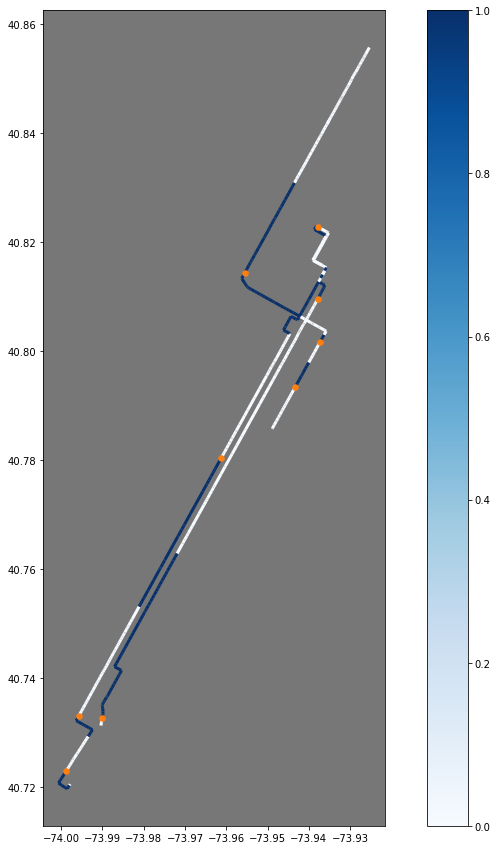

In [401]:
plot_results(xdf, ydf)